# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Luis Roberto Chávez Mancilla

**Professor**: Pablo Camarillo Ramirez

# Introduction
El data set utilizado es *10k Popular TV Shows Dataset 1944-2025 (TMDB)* 

En la actulidad el crecimiento sin medida del contenido audiovisual ha hecho cada vez mas dificil para las plataformas de streaming y las audiencias comprender las tendecias y las preferencias del publico. 
Ante esto el anális de los datos se vuelve una herramienta fundamental para que la industria del entretenimiento pueda tomar decisiones sobre produccion, localizacion y estrategias de recomendaciones a los usuarios.

En este proyecto se aborda la problematica de *analizar información relacionada con programas de TV*, en donde en nuestro data set se tienen inconsistencias como valores nulos, formatos incorrectos y estructuras no normalizadas. El propósito es preparar los datos para que puedan ser utilizados en análsis descriptivos y modelos analíticos sobre la popularidad, los géneros y la distribución geográfica de los shows de tv.

Para lograrlo, hacemos tranformaciones que limpian y estructura el dataset original, eliminando duplicados y registros con datos críticos faltantes. También se normalizan los textos, se convierten listas en formato de string a estructuras array, y se crean columnas derivadas como el año de lanzamiento. Además, se añaden indicadores para evaluar la completitud de ciertos campos y se generan tablas derivadas que permiten analizar la diversidad de géneros, países e idiomas, así como tendencias de popularidad a lo largo del tiempo.

# Dataset
Obtuve este dataset de Kaggle:
- https://www.kaggle.com/datasets/riteshswami08/10000-popular-tv-shows-dataset-tmdb

Para este proyecto el modelo seleccionado para nuestro pipeline es un *modelo relacional* usando un container de PostgreSQL como nuestro sistema de gestión.

Creo que en este caso un modelo relacional es lo mas adecuado debido a las relaciones naturales entre las entidades de nuestro data set (shows, generos y paises), lo cual facilita la integridad referencial, normalizacion y nos permite poder realizar analisis complejos mediante operaciones como joins y aggregations.

El esquema propuesto estaría compuesto por 5 tablas principales:
1. Shows (tabla con a información principal)

`id` - int

`name` - str

`original_name` - str

`original_language` - str

`first_air_date` - date(str)

`overview` - str

`popularity` - float

`vote_average` - float

`vote_count` - int

`adult` - int

`poster_path` - str

`backdrop_path` - str

2. Genres (lista de géneros disponibles en el data set)

`genre_id` - int

3. Show genres (tabla de relacion entre shows y generos)

`show_id` - int (fk)

`genre_id` - int (fk)

4. Countries (catálogo de países)

`country_code` - str

5. Show countries (relación entre shows y país de origen)

`show_id` - int

`country_code` - str

**Notas:** `genre_ids` y `origin_country` en el CSV vienen como strings tipo lista (ej. `"[18, 35]"` o `"['US']"`). En la etapa de ingestión se parsearán (con `ast.literal_eval` / `json.loads`) y se poblarán las tablas `genres` / `show_genres` y `countries` / `show_countries`. También se crearán columnas derivadas en Transformations (p. ej. `release_year`, `genre_count`, `weighted_popularity`).



# Transformations and Actions
### Create Spark Session

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Project batch processing - Part 1.") \
    .master("spark://spark-master:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()


sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

25/10/27 03:54:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Define schema

In [2]:
from robertoman.spark_utils import SparkUtils

# Definición de columnas para la tabla shows
shows_schema_columns = [
    ("adult", "boolean"),
    ("backdrop_path", "string"),
    ("genre_ids", "string"),
    ("id", "int"),
    ("origin_country", "string"),  
    ("original_language", "string"),
    ("original_name", "string"),
    ("overview", "string"),
    ("popularity", "float"),
    ("poster_path", "string"),
    ("first_air_date", "string"),   # convertir a date
    ("name", "string"),
    ("vote_average", "float"),
    ("vote_count", "int")
]

# Generamos el esquema
shows_schema = SparkUtils.generate_schema(shows_schema_columns)
shows_schema

StructType([StructField('adult', BooleanType(), True), StructField('backdrop_path', StringType(), True), StructField('genre_ids', StringType(), True), StructField('id', IntegerType(), True), StructField('origin_country', StringType(), True), StructField('original_language', StringType(), True), StructField('original_name', StringType(), True), StructField('overview', StringType(), True), StructField('popularity', FloatType(), True), StructField('poster_path', StringType(), True), StructField('first_air_date', StringType(), True), StructField('name', StringType(), True), StructField('vote_average', FloatType(), True), StructField('vote_count', IntegerType(), True)])

In [3]:
!pwd

/opt/spark/work-dir


### Load CSV

In [4]:
base_path = "/opt/spark/work-dir/data/"

df_shows = spark.read \
    .option("header", "true") \
    .schema(shows_schema) \
    .csv(base_path + "shows/")  

# df_shows.show(5, truncate=False)
df_shows.printSchema()

root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- genre_ids: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- origin_country: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_name: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- first_air_date: string (nullable = true)
 |-- name: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)



In [5]:
total_records = df_shows.count()
print(f"\nTotal de registros: {total_records}\n")


Total de registros: 10989



In [6]:
from pyspark.sql.functions import (
    to_date,
    year,
    col,
    count,
    when,
    trim,
    regexp_replace,
    from_json,
    length,
    avg,
    round
)

df = df_shows

# mostrar columnas con nulos
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+-------------+---------+---+--------------+-----------------+-------------+--------+----------+-----------+--------------+----+------------+----------+
|adult|backdrop_path|genre_ids| id|origin_country|original_language|original_name|overview|popularity|poster_path|first_air_date|name|vote_average|vote_count|
+-----+-------------+---------+---+--------------+-----------------+-------------+--------+----------+-----------+--------------+----+------------+----------+
|  989|          733|      105|989|           190|              213|          234|    1295|      2055|       1510|          1461|1524|        2166|      2288|
+-----+-------------+---------+---+--------------+-----------------+-------------+--------+----------+-----------+--------------+----+------------+----------+



In [7]:
# Definir columnas críticas (no pueden ser NULL), borramos registros con 
critical_columns = [
    "id",
    "original_name",
    "first_air_date",
    "popularity",
    "vote_average",
    "genre_ids",
    "origin_country",
]

text_cols = [
    "name",
    "original_name",
    "original_language",
    "overview",
    "poster_path",
    "backdrop_path",
    "genre_ids",
    "origin_country",
]

# en caso de duplicados (esto mantiene primera aparacion)
df = df.dropDuplicates(["id"])

# Manejo de nulos ---------------------------------
df = df.dropna(subset=critical_columns)

# Limpieza de str hacemos trim en columnas de texto ----------------------------

for i in text_cols:
    df = df.withColumn(i, trim(col(i)))

print(f"Antes de limpieza: {total_records}, despues de limpieza: {df.count()}")


Antes de limpieza: 10989, despues de limpieza: 8401


In [8]:
from pyspark.sql.types import ArrayType, IntegerType, StringType

# CONVERSIONES
# convertir first_air_date a (str) a date
df = df.withColumn(
    "first_air_date_parsed", to_date(col("first_air_date"), "yyyy-MM-dd")
)

# Reemplazamos la columna original por la convertida
df = df.drop("first_air_date").withColumnRenamed(
    "first_air_date_parsed", "first_air_date"
)

# crear esta columna para poder hacer analisis respecto al año de salida
df = df.withColumn("release_year", year(col("first_air_date")))
# ----------------------------------------------------------------------------------
# parsear columnas con "listas" (que en realidad son str) a arrays
df = df.withColumn("genre_ids_json", regexp_replace(col("genre_ids"), r"'", '"'))
df = df.withColumn(
    "genre_ids_arr", from_json(col("genre_ids_json"), ArrayType(IntegerType()))
)

# tenemos que cambiar las comillas simplles a dobles ya que los json no aceptan simples
df = df.withColumn(
    "origin_country_json", regexp_replace(col("origin_country"), r"'", '"')
)
df = df.withColumn(
    "origin_country_arr", from_json(col("origin_country_json"), ArrayType(StringType()))
)

# df.select("genre_ids", "genre_ids_arr").show(5, truncate=False)
# df.select("origin_country", "origin_country_arr").show(5, truncate=False)

In [9]:
# para las columnas que definimos como no criticas, no vamos a borrae el registros como tal
# ya que por ejemplo si un dato no tiene un path del poster del show no es necesario desechar el registro completo
# por lo que decidí mejor crear una columna flag para este tipo de columnas no criticas.
df = (
    df.withColumn(
        "has_overview",
        when(
            col("overview").isNotNull() & (length(col("overview")) > 0), True
        ).otherwise(False),
    )
    .withColumn(
        "has_poster",
        when(
            col("poster_path").isNotNull() & (length(col("poster_path")) > 0), True
        ).otherwise(False),
    )
    .withColumn(
        "has_backdrop",
        when(
            col("backdrop_path").isNotNull() & (length(col("backdrop_path")) > 0), True
        ).otherwise(False),
    )
)

# df.show(5, truncate=False)

In [10]:
# Popularidad promedio por idioma original
df_popularity_by_lang = (
    df.groupBy("original_language")
    .agg(round(avg("popularity"), 2).alias("avg_popularity"))
    .orderBy(col("avg_popularity").desc())
)

# Popularidad promedio por año de lanzamiento
df_popularity_by_year = (
    df.groupBy("release_year")
    .agg(round(avg("popularity"), 2).alias("avg_popularity"))
    .orderBy("release_year")
)

print(f"Count de popularidad por lenguage: {df_popularity_by_lang.count()}")
print(f"Count de popularidad por año: {df_popularity_by_year.count()}")

Count de popularidad por lenguage: 59


Count de popularidad por año: 80


### Normalizacion de las tablas
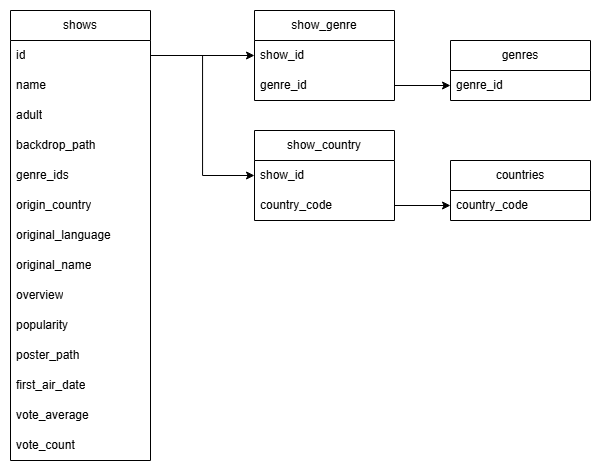

In [11]:
from pyspark.sql.functions import explode

unique_genres_count = (
    df.select(explode(col("genre_ids_arr")).alias("genre_id")).distinct().count()
)
unique_countries_count = (
    df.select(explode(col("origin_country_arr")).alias("country_code"))
    .distinct()
    .count()
)

print(f"Número de generos únicos: {unique_genres_count}")
print(f"Número de countries únicos: {unique_countries_count}")

Número de generos únicos: 18
Número de countries únicos: 82


In [12]:
# Obtener catalogo de ids de generos unicos
df_genres_catalog = df.select(
    explode(col("genre_ids_arr")).alias("genre_id")
).distinct()
# Obtener catalogo paises de origen unicos
df_countries_catalog = df.select(
    explode(col("origin_country_arr")).alias("country_code")
).distinct()

print(f"Numero de registros del catalogo de generos: {df_genres_catalog.count()}")
print(f"Numero de registros de catalogo de countries: {df_countries_catalog.count()}")

# df_genres_catalog.show(18, truncate=False)
# df_countries_catalog.show(82, truncate=False)

Numero de registros del catalogo de generos: 18
Numero de registros de catalogo de countries: 82


In [13]:
from pyspark.sql.functions import lit, create_map

genre_mapping = {
    10759: "Action & Adventure",
    16: "Animation",
    35: "Comedy",
    36: "History",
    37: "Western",
    80: "Crime",
    99: "Documentary",
    18: "Drama",
    10751: "Family",
    10749: "Romance",
    10762: "Kids",
    9648: "Mystery",
    10763: "News",
    10764: "Reality",
    10765: "Sci-Fi & Fantasy",
    10766: "Soap",
    10767: "Talk",
    10768: "War & Politics"
}

# Crear un mapeo de PySpark para agregar la columna genre_name al DataFrame existente
mapping_expr = create_map([lit(x) for x in sum(genre_mapping.items(), ())])

# Agregar la columna genre_name al DataFrame df_genres_catalog existente
df_genres_catalog_mapped = df_genres_catalog.withColumn(
    "genre_name", 
    mapping_expr[col("genre_id")]
)

print(f"Catálogo de géneros con nombres: {df_genres_catalog_mapped.count()} registros")

Catálogo de géneros con nombres: 18 registros


In [14]:
# Tabla puente shows - genres
df_shows_genres = df.select(
    col("id").alias("show_id"), explode(col("genre_ids_arr")).alias("genre_id")
).distinct()

# Tabla puente shows - countries
df_shows_countries = df.select(
    col("id").alias("show_id"), explode(col("origin_country_arr")).alias("country_code")
).distinct()

print(f"Numero de registros de relaciones genres: {df_shows_genres.count()}")
print(f"Numero de registros de relaciones countries: {df_shows_countries.count()}")

Numero de registros de relaciones genres: 17813
Numero de registros de relaciones countries: 8734


In [15]:
from pyspark.sql.functions import countDistinct

# Número de shows por país
df_shows_by_country = (
    df_shows_countries.groupBy("country_code")
    .agg(countDistinct("show_id").alias("num_shows"))
    .orderBy(col("num_shows").desc())
)

# df_shows_by_country.show(10, truncate=False)

In [16]:
df_shows_clean = df.select(
    "id",
    "original_name",
    "original_language",
    "adult",
    "overview",
    "popularity",
    "first_air_date",
    "release_year",
    "vote_average",
    "vote_count",
    "has_overview",
    "has_poster",
    "has_backdrop",
)

df_shows_clean.printSchema()
# df_shows_clean.show(10, truncate=False)

root
 |-- id: integer (nullable = true)
 |-- original_name: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- first_air_date: date (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- has_overview: boolean (nullable = false)
 |-- has_poster: boolean (nullable = false)
 |-- has_backdrop: boolean (nullable = false)



# Persistence Data

#### Justificación

El dataset nos presenta una estructura relacional porque hay entidades bien definidas como `shows`, `generos` y `paises`.
Además, se presentan relaciones muchos a muchos:
- show puede tener múltiples géneros (drama, comedia, etc.). 
- Un género puede estar en múltiples shows
- Un show puede ser producido en múltiples países
- un país puede producir multiples shows

Con nuestro enfoque podemos tener un esquema normalizado en donde se reduce significativamente el almacenamiento.

Cada show almacena: "[18, 35]" y "['US', 'GB']":




In [17]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "shows"

df_shows_clean.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print(f"DataFrame '{table_name}' written into a PosgreSQL DB !")

25/10/27 03:54:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame 'shows' written into a PosgreSQL DB !


In [18]:
table_name = "genres"
df_genres_catalog_mapped.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print(f"DataFrame '{table_name}' written into a PosgreSQL DB !")


DataFrame 'genres' written into a PosgreSQL DB !


In [19]:
table_name = "show_genres"
df_shows_genres.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print(f"DataFrame '{table_name}' written into a PosgreSQL DB !")

DataFrame 'show_genres' written into a PosgreSQL DB !


In [20]:
table_name = "countries"
df_countries_catalog.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print(f"DataFrame '{table_name}' written into a PosgreSQL DB !")

DataFrame 'countries' written into a PosgreSQL DB !


In [21]:
table_name = "show_countries"
df_shows_countries.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print(f"DataFrame '{table_name}' written into a PosgreSQL DB !")

DataFrame 'show_countries' written into a PosgreSQL DB !


In [22]:
table_name = "show_by_country"
df_shows_by_country.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print(f"DataFrame '{table_name}' written into a PosgreSQL DB !")

DataFrame 'show_by_country' written into a PosgreSQL DB !


In [23]:
table_name = "popularity_by_lenguage"
df_popularity_by_lang.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print(f"DataFrame '{table_name}' written into a PosgreSQL DB !")


DataFrame 'popularity_by_lenguage' written into a PosgreSQL DB !


In [24]:
table_name = "popularity_by_year"
df_popularity_by_year.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print(f"DataFrame '{table_name}' written into a PosgreSQL DB !")


DataFrame 'popularity_by_year' written into a PosgreSQL DB !


In [25]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"

table_name = "shows"

db_properties = {
      "user": "postgres",      
      "password": "Admin@1234",
      "driver": "org.postgresql.Driver"
  }

shows_from_db = spark.read \
    .jdbc(url=jdbc_url, table=table_name, properties=db_properties)

shows_from_db.printSchema()
shows_from_db.show(5, truncate=False)

root
 |-- id: integer (nullable = true)
 |-- original_name: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- first_air_date: date (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- has_overview: boolean (nullable = true)
 |-- has_poster: boolean (nullable = true)
 |-- has_backdrop: boolean (nullable = true)

+---+--------------------------+-----------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"

table_name = "genres"

db_properties = {
      "user": "postgres",      
      "password": "Admin@1234",
      "driver": "org.postgresql.Driver"
  }

genre_catalog_from_db = spark.read \
    .jdbc(url=jdbc_url, table=table_name, properties=db_properties)

genre_catalog_from_db.printSchema()
genre_catalog_from_db.show(5, truncate=False)

root
 |-- genre_id: integer (nullable = true)
 |-- genre_name: string (nullable = true)

+--------+------------------+
|genre_id|genre_name        |
+--------+------------------+
|35      |Comedy            |
|10766   |Soap              |
|10751   |Family            |
|10749   |Romance           |
|10759   |Action & Adventure|
+--------+------------------+
only showing top 5 rows


In [27]:
# Contar registros
total = shows_from_db.count()
print(f"Total de registros en la BD: {total}")

Total de registros en la BD: 8401


# DAG

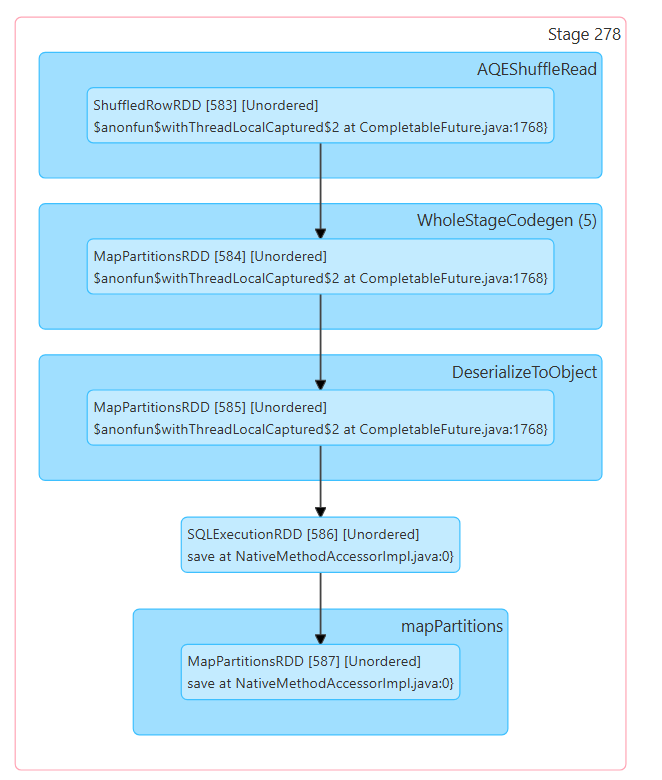

In [28]:
sc.stop()